# Assignment 2

**Assignment 2: Sampling**

**Goal**: ​​Get familiar with sampling methods by implementing these methods and applying them to a given probability distribution.

In this assignment we are going to learn about sampling methods. The goal is to implement *Metropolis-Hastings** (MH) algorithm and **Simulated Annealing** (SA) algorithm and analyze their behavior. Importantly, we aim at noticing differences between these two methods.

Here, we are interested in ​**sampling**​ from a mixture of two Gaussians, namely:

$$
p(\mathbf{x}) = 0.25\cdot \mathcal{N}\left(\mu = \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix} \right) + 0.75\cdot \mathcal{N}\left(\mu = \begin{bmatrix} -3 \\ -3 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

In this assignemnt, you are asked to implement:
1. The Metropolis-Hastings (MH) algorithm.
2. The simulated annealing (SA) algorithm.

After implementing both methods, please run experiments and compare both methods. Please follow all instructions.

## 1. Understanding the probability distribution

Please run the code below and visualize the probability distribution. Please try to understand this distribution, what the modes are (you can do it by inspecting the plot). What are possible problems here?

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

EPS = 1.0e-7

In [2]:
# PLEASE DO NOT REMOVE!
# The definition of the probability distribution.
mv1 = multivariate_normal(mean=[2.0, 2.0], cov=[[1.0, 0.5], [0.5, 1.0]])
mv2 = multivariate_normal(mean=[-3.0, -3.0], cov=[[1.0, 0.0], [0.0, 1.0]])


def prob(x):
    return 0.25 * mv1.pdf(x) + 0.75 * mv2.pdf(x)

In [3]:
# PLEASE DO NOT REMOVE!
# Calculating the probability distribution.
def calculate_p(x1, x2):
    p_x = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            p_x.append(prob(np.asarray([[x1[i], x2[j]]])))

    return np.asarray(p_x).reshape(len(x1), len(x2))

In [4]:
# PLEASE DO NOT REMOVE!
# Define coordinates
x1 = np.linspace(-10.0, 10.0, 400)
x2 = np.linspace(-10.0, 10.0, 400)

# Calculate the objective
p_x = calculate_p(x1, x2).reshape(len(x1), len(x2))

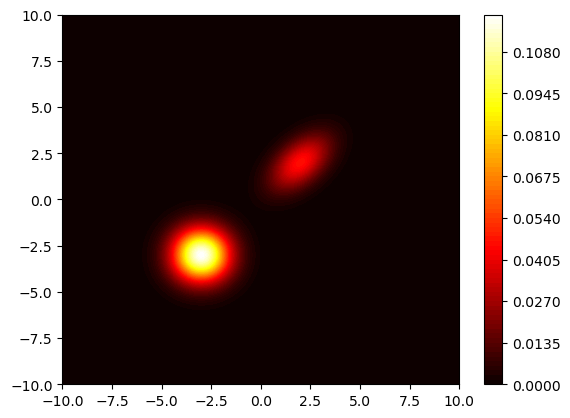

In [5]:
# PLEASE DO NOT REMOVE!
# Plot the objective
plt.contourf(x1, x2, p_x, 100, cmap="hot")
plt.colorbar()

**Question 1 (0-0.5pt):** How many modes do we have and what are they? What is the most probable point?

**Answer:**

We have two modes, one in [-3,-3] and one in [2,2]. The most probably point is [-3,-3]. These are because mean is a maximum of a gaussian, and we have the means as two local maximums in mixture of two gaussians.  

## 2. The Metropolis-Hastings algorithm

First, you are asked to implement the Metropolis-Hastings (MH) algorithm. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

NOTE: To implement the MH algorithm, you need to specify the proposal distribution.

**Question 2 (0-0.5pt):** What is the proposal distribution, $q(\mathbf{x}_{new} | \mathbf{x}_{old})$, in your case?

**Answer:**

Gaussian distribution

**Question 3 (0-0.5pt):** Is your proposal a proper proposal distribution? (That is, it must fulfill irreducibility and aperiodicity, see Andrieu et al., "An Introduction to MCMC for Machine Learning".)

**Answer:**

Yes, it can visit all states and does not get trapped in loops given our stdev.

In [6]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# =========
# Implement the Metropolis Hastings (MH) algorithm.
# It might be you use another arguments beside standard deviation (std).
# Please add them then.


class MetropolisHastings(object):
    def __init__(self, x, prob, std=0.1, std_enlarge=100):
        self.prob = prob
        self.std = std
        self.x_old = x
        self.std_enlarge = std_enlarge

    def proposal(self, x):
        # PLEASE FILL IN
        # ...
        # x_new = ...

        x_new = np.random.multivariate_normal(x[0], [[self.std_enlarge*std,0], [0,self.std_enlarge*std]], 1)
        return x_new

    def evaluate(self, x_new, x_old):
        # PLEASE FILL IN
        # A = ...
        
        #new times old<given new
        cov = [[self.std_enlarge*std,0], [0,self.std_enlarge*std]]
        q_xt_given_x = multivariate_normal(x_new[0], cov).pdf(x_old)
        q_x_given_xt = multivariate_normal(x_old[0], cov).pdf(x_new)
        A = prob(x_new)*q_xt_given_x/(prob(x_old) * q_x_given_xt )
        
        return np.minimum(1.0, A)

    def select(self, x_new, A):
        # PLEASE FILL IN
        # ...
        # NOTE: If a new candidate is not selected, we must return self.x_old
        u = np.random.uniform(0,1,1) #one element selected uniform in 0,1
        
        #since x_new is the proposed answer, if its not accepted we return the old one.
        if( A <= u ):
            x_new = self.x_old
        return x_new
    
    def step(self):
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

In [7]:
# PLEASE DO NOT REMOVE!
# An auxiliary function for plotting.
def plot_sampling_process(ax, sampler, title):
    # Plot the objective function
    ax.contourf(x1, x2, p_x / p_x.sum(), 100, cmap="hot")

    # Init the solution
    x_samp = sampler.x_old
    # Run the optimization algorithm
    count = 0  # we calculate how many of new candidates were accepted
    for i in range(num_epochs):
        x = sampler.step()

        if (x == x_samp[-1]).all():
            pass
        else:
            count = count + 1
            x_samp = np.concatenate((x_samp, x), 0)

    ax.scatter(x_samp[:, 0], x_samp[:, 1], marker="+")
    # We add AR (Acceptance Rate) to the title.
    ax.set_title(title + " AR={:.2f}".format(count / num_epochs))

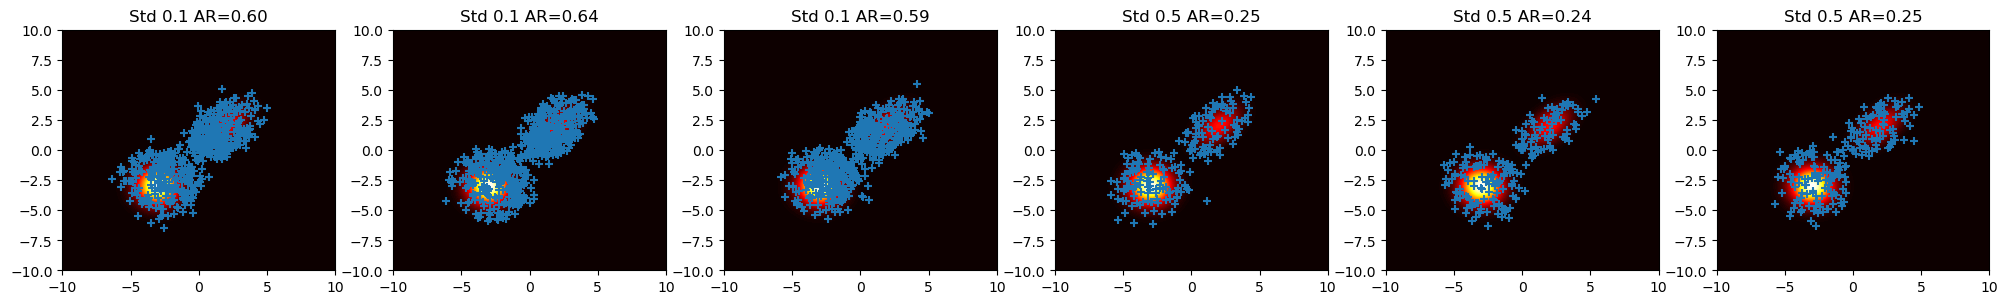

In [8]:
# PLEASE DO NOT REMOVE!
# Running the MH algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5]  # we repeat experiments 3 times per std

## If you add any other hyperparameters, please include them during init!
## However, please do not include them in the for-loop. It should stay for stds only.

std_enlarge = 100 #This changes the step size, otherwise the algorithm does not jump far enough. Found the number by trial and error.

# plotting the convergence of the MH
fig_mh, axs = plt.subplots(1, len(stds), figsize=(20, 3))
fig_mh.tight_layout()

x_init = np.asarray([[0.0, 0.0]])

for i in range(len(stds)):
    # take the std
    std = stds[i]
    # init the MH
    mh = MetropolisHastings(x=x_init, prob=prob, std=std, std_enlarge=std_enlarge)
    # plot the convergence
    plot_sampling_process(axs[i], sampler=mh, title="Std " + str(mh.std))

**Question 4 (0-0.5)**: Please comment on the behavior of the MH for different values of the standard deviation. Is it always possible to sample from both modes theoretically? What did you observe in practice on plots? 

**Answer**:

The std is related to step size. If it is big, then we may jump further. If the distance between modes are significantly smaller than the stdev, then the algorithm is highly unlikely to jump that far. This results in being stuck in a node. On my practice plots, I observed that without std_enlarge, the algorithm couldn't even reach the modes, and with the given value, it can find both modes. Also the number of samples are different because of different acceptances.

**Question 5 (0-0.5)**: Please comment on the acceptance ratio (AR) for std=0.1 and std=0.5. How can you explain the difference?

**Answer**:

With a smaller std, if we are near a probable point, then it is more likely that we will get similar probable points which will be accepted as the function is continuous. This explains why AR for std=0.1 is higher than std=0.5. In the latter, we can see that the gap in the middle was not accepted because the algorithm could jump over it faster.

## 3. The simulated annealing (SA) sampling

In the second part of this assignment, you are asked to implement the Simulated Annealing (SA) algorithm with cooling scheme as dicussed during the lecture.

**Question 6 (0-0.5pt)**: Please explain what is the difference between MH and SA?

**Answer**:

SA makes step size smaller as it is iterated, but MH does not.

**Question 7 (0-0.5pt)**: Why is SA sometimes more preferrable than MH? Which of these two methods would you use for optimization (not sampling)?

**Answer**:

I would use SA for optimization because it is more converging, as exploration is reduced with time. I would prefer SA over MH when there are many modes, because it can jump over many of them at the beginning then find the best one, whereas MH would keep jumping and sampling all over.

In [ ]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# NOTE: The cooling scheme must be properly implemented!
# =========
# Implement the Simulated Annealing (SA) algorithm.
# It is equivalent to implementing the step function.
class SimulatedAnnealing(object):
    def __init__(self, x, prob, std=0.1, T0=1.0, C=1.0):
        self.prob = prob
        self.std = std
        self.x_old = x
        self.T0 = T0
        self.C = C
        self.t = 0  # we init the step number to 0; we need it for cooling scheme

    def proposal(self, x):
        # PLEASE FILL IN
        # ...
        # x_new = ...
        return x_new

    def evaluate(sef, x_new, x_old, T):
        # PLEASE FILL IN
        # ...
        # A = ...
        return np.minimum(1.0, A)

    def select(self, x_new, A):
        # PLEASE FILL IN
        # ...

    def step(self):
        # The temperature scheme (the cooling scheme)
        # PLEASE FILL IN
        # T = ...
        self.t = self.t + 1
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old, T)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

In [ ]:
# PLEASE DO NOT REMOVE!
# Running the SA algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds_sa = [
    0.1,
    0.1,
    0.1,
    0.5,
    0.5,
    0.5,
]  # values of std; notice we repeat them due to randomness
T0s = [0.1, 1.0, 10.0]  # values of T0
Cs = [0.1, 1.0, 10.0]  # values of C

# plotting the convergence of the MH
fig_sa, axs = plt.subplots(len(Cs) * len(T0s), len(stds_sa), figsize=(20, 18))
fig_sa.tight_layout()

# Always start with the same point
x_init = np.asarray([[0.0, 0.0]])

# START SA
for i in range(len(Cs)):
    # Take a value for C
    C = Cs[i]
    for k in range(len(T0s)):
        # Take a value for the init temperature T0
        T0 = T0s[k]
        for j in range(len(stds_sa)):
            # take the std
            std = stds_sa[j]
            # init the SA
            sa = SimulatedAnnealing(x=x_init, prob=prob, std=std, T0=T0, C=C)
            # plot the sampling process
            plot_sampling_process(
                axs[len(T0s) * i + k, j],
                sampler=sa,
                title="Std " + str(sa.std) + " T0 " + str(T0) + " C " + str(C),
            )